In [1]:
# calculate ndvi
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

In [2]:
area_of_interest = {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              77.57423513459304,
              12.990852811348162
            ],
            [
              77.57423513459304,
              12.965770763305429
            ],
            [
              77.60526364722165,
              12.965770763305429
            ],
            [
              77.60526364722165,
              12.990852811348162
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
bbox = rasterio.features.bounds(area_of_interest)

In [3]:
bbox

(77.57423513459304, 12.965770763305429, 77.60526364722165, 12.990852811348162)

In [4]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = stac.search(
    bbox=bbox,
    datetime="2023-01-01/2023-06-10",
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 25}},
)

items = search.item_collection()
print(len(items))

20


In [5]:
data = (
    stackstac.stack(
        items,
        assets=["B08", "B04"],  # red, green, blue
        resolution=10,
        bounds_latlon=bbox
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-5b9d8e91151d314cb2fee4ccf433d2d7' (time: 20,
                                                                band: 2,
                                                                y: 282, x: 341)>
dask.array<where, shape=(20, 2, 282, 341), dtype=float64, chunksize=(1, 1, 282, 341), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2023-01-03...
    id                                       (time) <U54 'S2A_MSIL2A_20230103...
  * band                                     (band) <U3 'nir' 'red'
  * x                                        (x) float64 7.792e+05 ... 7.826e+05
  * y                                        (y) float64 1.438e+06 ... 1.435e+06
    s2:dark_features_percentage              (time) float64 0.06272 ... 0.03494
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      float64 10.0
    common_name                              (band) <U3 'nir' 'red'
    center_wavelength                        (band) float64 0.842 0.665
    full_width_half_max                      (band) float64 0.145 0.038
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(779240, 1434750, 782650, 1437...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 779240.00|\n| 0.00,-10.00, 1437570.00|\n| 0.0...
    resolution:  10

In [6]:
data = data.groupby("time.day").median()

In [7]:
data['ndvi'] = (data.sel(band="nir") -  data.sel(band="red"))/ (data.sel(band="nir") + data.sel(band="red"))

In [8]:
data

<xarray.DataArray 'stackstac-5b9d8e91151d314cb2fee4ccf433d2d7' (day: 13,
                                                                band: 2,
                                                                y: 282, x: 341)>
dask.array<stack, shape=(13, 2, 282, 341), dtype=float64, chunksize=(1, 1, 282, 341), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * band                                     (band) <U3 'nir' 'red'
  * x                                        (x) float64 7.792e+05 ... 7.826e+05
  * y                                        (y) float64 1.438e+06 ... 1.435e+06
    s2:mgrs_tile                             <U5 '43PGQ'
    s2:snow_ice_percentage                   float64 0.0
    sat:orbit_state                          <U10 'descending'
    ...                                       ...
    common_name                              (band) <U3 'nir' 'red'
    center_wavelength                        (band) float64 0.842 0.665
    full_width_half_max                      (band) float64 0.145 0.038
    epsg                                     int64 32643
  * day                                      (day) int64 3 4 7 8 ... 19 22 23 28
    ndvi                                     (day, y, x) float64 dask.array<chunksize=(1, 282, 341), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(779240, 1434750, 782650, 1437...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 779240.00|\n| 0.00,-10.00, 1437570.00|\n| 0.0...
    resolution:  10

In [9]:
ndvi = xr.concat(data.ndvi, dim="time")

In [10]:
data.ndvi

<xarray.DataArray 'ndvi' (day: 13, y: 282, x: 341)>
dask.array<truediv, shape=(13, 282, 341), dtype=float64, chunksize=(1, 282, 341), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * x                                        (x) float64 7.792e+05 ... 7.826e+05
  * y                                        (y) float64 1.438e+06 ... 1.435e+06
    s2:mgrs_tile                             <U5 '43PGQ'
    s2:snow_ice_percentage                   float64 0.0
    sat:orbit_state                          <U10 'descending'
    s2:datatake_type                         <U8 'INS-NOBS'
    ...                                       ...
    proj:bbox                                object {699960.0, 809760.0, 1390...
    proj:shape                               object {10980}
    gsd                                      float64 10.0
    epsg                                     int64 32643
  * day                                      (day) int64 3 4 7 8 ... 19 22 23 28
    ndvi                                     (day, y, x) float64 dask.array<chunksize=(1, 282, 341), meta=np.ndarray>

/tmp/ipykernel_508/369138196.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


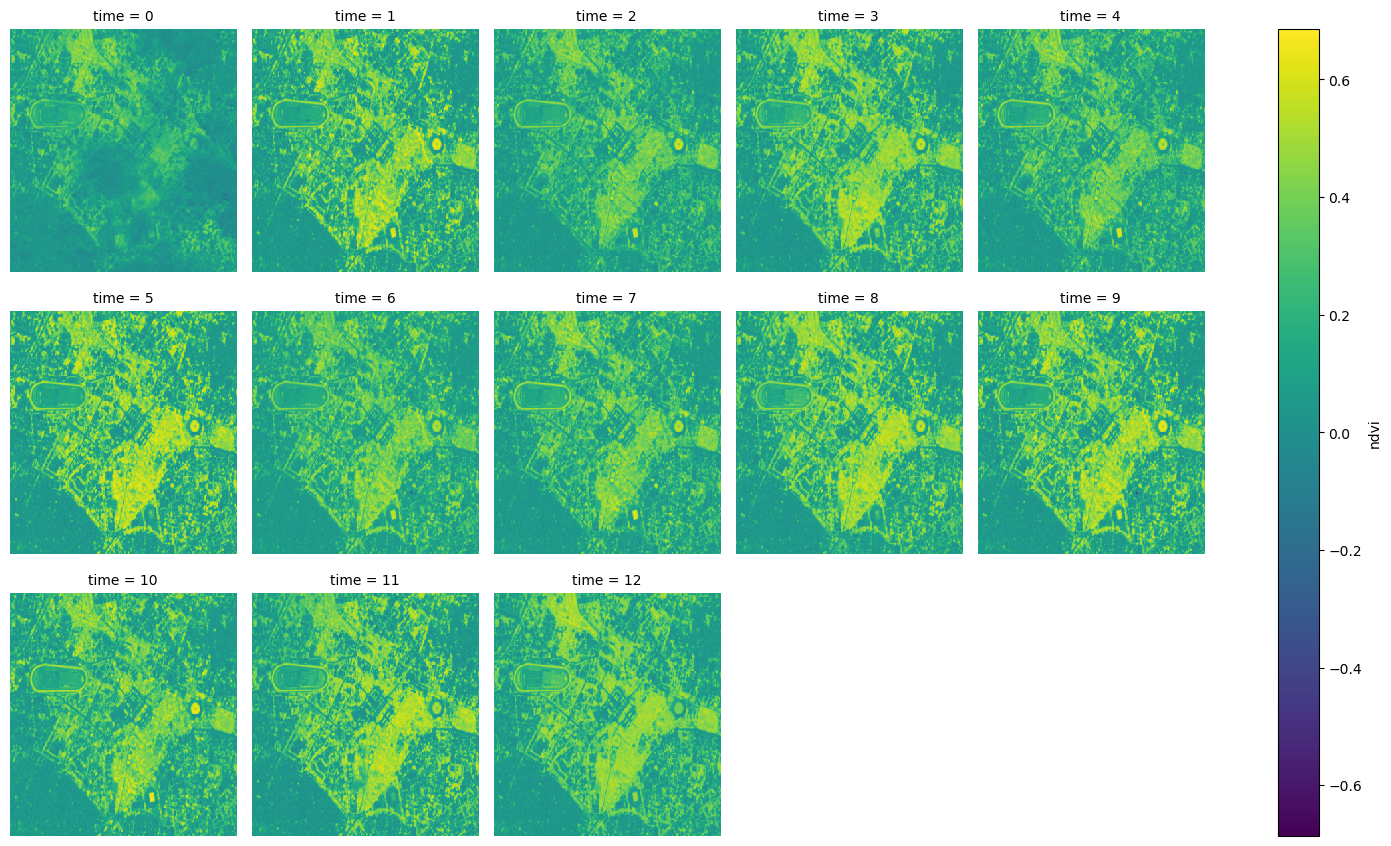

In [11]:
g = ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=5, cmap="viridis");
for ax in g.axes.flat:
    ax.set_axis_off()

### More reading
https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/